### Lab 2.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vando\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Preprocess data

In [2]:
df = pd.read_csv("data.csv", sep=';')
df.isna().any()

title          False
genre          False
description     True
img_link       False
dtype: bool

In [3]:
df = df.dropna()

In [4]:
df.isna().any()

title          False
genre          False
description    False
img_link       False
dtype: bool

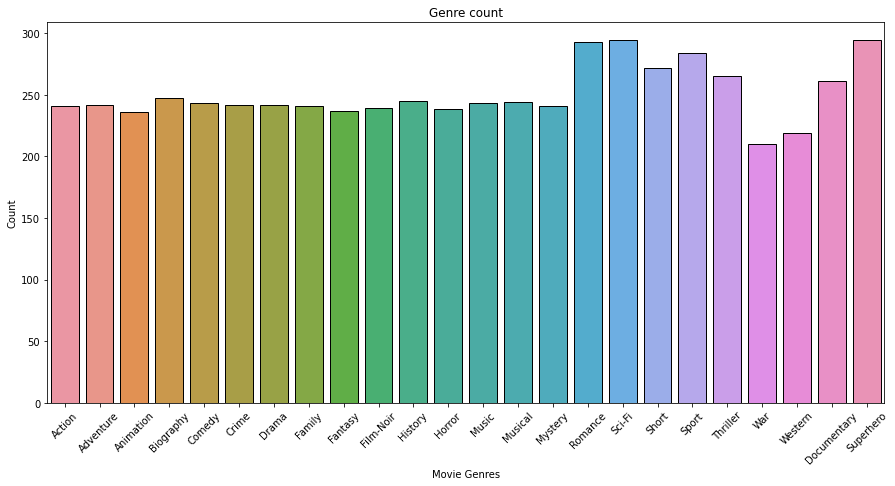

In [5]:
plt.figure(figsize=(15,7))
sns.countplot(x='genre', data=df, edgecolor=(0,0,0))
plt.xticks(rotation=45)
plt.xlabel('Movie Genres')
plt.ylabel('Count')
plt.title('Genre count')
plt.show()

In [6]:
df.head()

,title,genre,description,img_link
0,Black Panther: Wakanda Forever,Action,The people of Wakanda fight to protect their h...,Action_01.jpg
1,Andor,Action,Prequel series to Star Wars' 'Rogue One'. In a...,Action_02.jpg
2,Black Adam,Action,"Nearly 5,000 years after he was bestowed with ...",Action_03.jpg
3,House of the Dragon,Action,An internal succession war within House Targar...,Action_04.jpg
4,Warrior Nun,Action,"After waking up in a morgue, an orphaned teen ...",Action_05.jpg


In [12]:
#genre_mapper = {'Action': 0, 'Adventure': 1, 'Animation': 2, 'Biography':3, 'Comedy':4, 'Crime':5, 'Documentary':6, 'Drama':7, 'Family': 8,
#                'Fantasy': 9, 'Film-Noir': 10, 'History': 11, 'Horror':12, 'Music':13, 'Musical':14, 'Mystery':15, 'Romance':16, 'Sci-Fi': 17,
#                'Short': 18, 'Sport': 19, 'Superhero': 20, 'Thriller':21, 'War':22, 'Western':23}
#df['genre'] = df['genre'].map(genre_mapper)
#df.head(10)

### Text preprocessing

In [7]:
# Text preprocessing

def preprocess_text(text, stemm=False, lemm=True, stopwords=None):
  # Remove punctuations, lowercase, strip
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
          
  # Tokenize
  texts = text.split()    
  # Remove Stopwords
  if stopwords is not None:
      texts = [word for word in texts if word not in stopwords]
              
  # Stemming
  if stemm == True:
      ps = nltk.stem.porter.PorterStemmer()
      texts = [ps.stem(word) for word in texts]
              
  # Lemmatisation
  if lemm == True:
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      texts = [lem.lemmatize(word) for word in texts]
          
  # Collect lists
  text = " ".join(texts)
  return text

In [8]:
# Loading stopwords dict
stopwords = nltk.corpus.stopwords.words("english")

In [9]:
# Doing preprocessing on texts
df['clean_title'] = df["title"].apply(lambda x: 
          preprocess_text(x, stemm=False, lemm=True, stopwords=stopwords))
df['clean_description'] = df["description"].apply(lambda x: 
          preprocess_text(x, stemm=False, lemm=True, stopwords=stopwords))
df.head()

,title,genre,description,img_link,clean_title,clean_description
0,Black Panther: Wakanda Forever,Action,The people of Wakanda fight to protect their h...,Action_01.jpg,black panther wakanda forever,people wakanda fight protect home intervening ...
1,Andor,Action,Prequel series to Star Wars' 'Rogue One'. In a...,Action_02.jpg,andor,prequel series star war rogue one era filled d...
2,Black Adam,Action,"Nearly 5,000 years after he was bestowed with ...",Action_03.jpg,black adam,nearly 5000 year bestowed almighty power egypt...
3,House of the Dragon,Action,An internal succession war within House Targar...,Action_04.jpg,house dragon,internal succession war within house targaryen...
4,Warrior Nun,Action,"After waking up in a morgue, an orphaned teen ...",Action_05.jpg,warrior nun,waking morgue orphaned teen discovers posse su...


In [16]:
#one_hot = pd.get_dummies(df['genre'])
#df = df.drop(['genre'], axis = 1)
#df = df.join(one_hot)
#df

In [17]:
#df.to_csv('data_cleaned.csv', sep=';', index=None)

In [18]:
#genre_mapper = {'Action': 0, 'Adventure': 1, 'Animation': 2, 'Biography':3, 'Comedy':4, 'Crime':5, 'Documentary':6, 'Drama':7, 'Family': 8,
#                'Fantasy': 9, 'Film-Noir': 10, 'History': 11, 'Horror':12, 'Music':13, 'Musical':14, 'Mystery':15, 'Romance':16, 'Sci-Fi': 17,
#                'Short': 18, 'Sport': 19, 'Superhero': 20, 'Thriller':21, 'War':22, 'Western':23}
#df['genre'] = df['genre'].map(genre_mapper)
#df.head(10)

In [10]:
df["text"] = df["clean_title"] + " " + df["clean_description"]
df = df[['text', 'genre', 'img_link']]
df.head()

,text,genre,img_link
0,black panther wakanda forever people wakanda f...,Action,Action_01.jpg
1,andor prequel series star war rogue one era fi...,Action,Action_02.jpg
2,black adam nearly 5000 year bestowed almighty ...,Action,Action_03.jpg
3,house dragon internal succession war within ho...,Action,Action_04.jpg
4,warrior nun waking morgue orphaned teen discov...,Action,Action_05.jpg


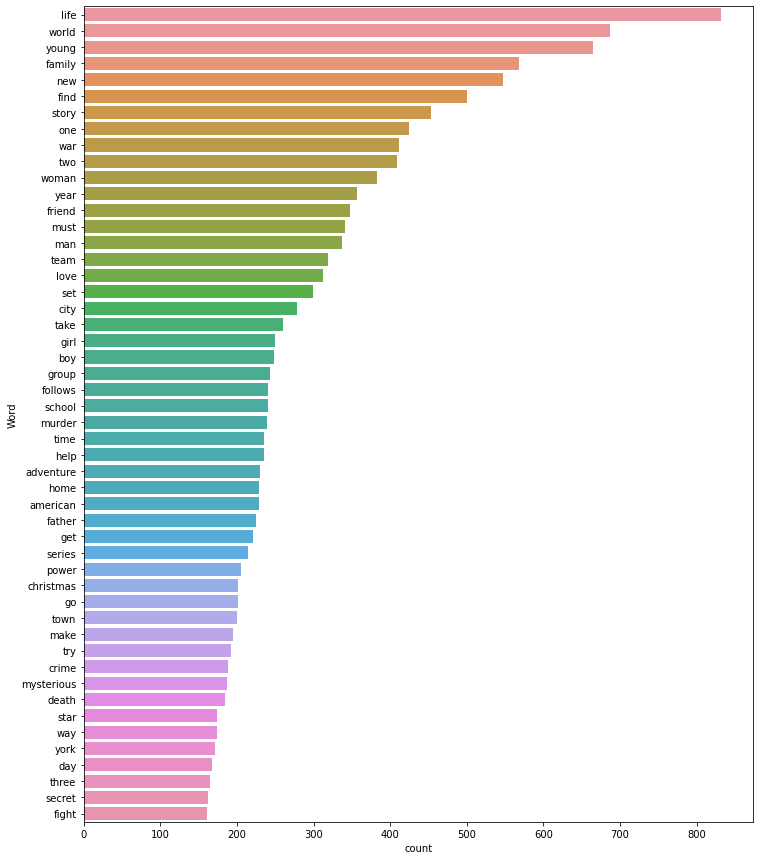

In [11]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(df['text'], 50)

## Text model

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genre'])

# transform target variable
y = multilabel_binarizer.transform(df['genre'])

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [59]:
xtrain_with_genre, xval_with_genre, ytrain, yval = train_test_split(df[['text', 'genre']], y, test_size=0.2, random_state=9)
xtrain = xtrain_with_genre['text']
xval = xval_with_genre['text']

1203

In [58]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [16]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [17]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [18]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [19]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [20]:
y_pred[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0])

In [21]:
f1_score(yval, y_pred, average="micro")
# this is for threshhold 0.5

0.37690776376907764

In [48]:
# predict probabilities
text_prediction = y_pred_prob = clf.predict_proba(xval_tfidf)
text_prediction

array([[0.05288463, 0.14795591, 0.03429724, ..., 0.16399092, 0.05447844,
        0.29397498],
       [0.06993708, 0.09698087, 0.04747413, ..., 0.20942056, 0.04045166,
        0.41631079],
       [0.03717201, 0.09105087, 0.03028053, ..., 0.20668128, 0.03031846,
        0.4302937 ],
       ...,
       [0.07122691, 0.08618844, 0.03218162, ..., 0.09072971, 0.02197603,
        0.2670499 ],
       [0.10021501, 0.10459592, 0.04278218, ..., 0.11255687, 0.03114869,
        0.24868673],
       [0.03186764, 0.1104118 , 0.04597602, ..., 0.29059687, 0.0359065 ,
        0.29836894]])

In [47]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)
y_pred_new

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.5238741517581739

## Image model
### Libs and hyperparams

In [27]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

image_width, image_height = 300, 300
directory_data_train= 'images/train'
directory_data_validation= 'images/test'

train_sample = 1450
validation_sample = 850
epochs = 50
lot_size = 20
if K.image_data_format() != 'channels_first':
     input_shape = (image_width, image_height, 3)
else:
     input_shape = (3, image_width, image_height)   

### Model description

In [28]:
pattern = keras.models.Sequential()

pattern.add(keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
pattern.add(keras.layers.Activation('relu'))
pattern.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

pattern.add(keras.layers.Conv2D(32, (3, 3)))
pattern.add(keras.layers.Activation('relu'))
pattern.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

pattern.add(keras.layers.Conv2D(64, (3, 3)))
pattern.add(keras.layers.Activation('relu'))
pattern.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

pattern.add(keras.layers.Flatten())
pattern.add(keras.layers.Dense(64))
pattern.add(keras.layers.Activation('relu'))
pattern.add(keras.layers.Dropout(0.5))
pattern.add(keras.layers.Dense(24))# число классов
pattern.add(keras.layers.Activation('softmax'))

pattern.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [29]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 128, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 128)
train_processing = train_datagen.flow_from_directory(
    directory_data_train,
    target_size=(image_width, image_height),
    batch_size=lot_size,
    class_mode='categorical')
validation_processing= test_datagen.flow_from_directory(
    directory_data_validation,
    target_size=(image_width, image_height),
    batch_size=lot_size,
    class_mode='categorical')

Found 5314 images belonging to 24 classes.
Found 649 images belonging to 24 classes.


### Training

In [30]:
pattern.fit(
    train_processing,
    steps_per_epoch=train_sample // lot_size,
    epochs=epochs,
    validation_data=validation_processing,
    validation_steps=validation_sample  // lot_size)

Epoch 1/50
72/72 [==============================] - 35s 377ms/step - loss: 3.7124 - accuracy: 0.0425 - val_loss: 3.1783 - val_accuracy: 0.0462
Epoch 2/50
72/72 [==============================] - 25s 345ms/step - loss: 3.1886 - accuracy: 0.0403
Epoch 3/50
72/72 [==============================] - 24s 338ms/step - loss: 3.1899 - accuracy: 0.0451
Epoch 4/50
72/72 [==============================] - 25s 347ms/step - loss: 3.1976 - accuracy: 0.0535
Epoch 5/50
72/72 [==============================] - 24s 336ms/step - loss: 3.1763 - accuracy: 0.0558
Epoch 6/50
72/72 [==============================] - 25s 339ms/step - loss: 3.1866 - accuracy: 0.0535
Epoch 7/50
72/72 [==============================] - 25s 341ms/step - loss: 3.1724 - accuracy: 0.0586
Epoch 8/50
72/72 [==============================] - 24s 334ms/step - loss: 3.1734 - accuracy: 0.0604
Epoch 9/50
72/72 [==============================] - 25s 343ms/step - loss: 3.1675 - accuracy: 0.0562
Epoch 10/50
72/72 [==============================

In [36]:
pattern.save_weights('first_model_weights.h5') #Сохранение весов модели
pattern.save('path') #Сохранение модели
pattern.load_weights('first_model_weights.h5') # Загрузка весов модели
image_prediction = pattern.predict(validation_processing) #Использование модели для предсказания
image_prediction

INFO:tensorflow:Assets written to: path\assets


array([[0.07904281, 0.05828839, 0.0182509 , ..., 0.09746155, 0.0279987 ,
        0.01086622],
       [0.03709267, 0.04230238, 0.02700934, ..., 0.01881019, 0.03618023,
        0.07000037],
       [0.05710938, 0.05034692, 0.01551873, ..., 0.09050318, 0.03324211,
        0.01894473],
       ...,
       [0.03440319, 0.03021442, 0.00995937, ..., 0.01477079, 0.07878499,
        0.11233975],
       [0.04690287, 0.03593316, 0.10298908, ..., 0.02491231, 0.02482214,
        0.03594832],
       [0.00687458, 0.00461717, 0.01341993, ..., 0.00533732, 0.0300041 ,
        0.22641417]], dtype=float32)

## Meta model
Model that learns how to best combine the predictions of the base models

In [65]:
from sklearn import tree
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Prepare data

Combine output vectors of two base models into one vector per sample for the input of meta model

In [62]:
samples_num = min(len(text_prediction), len(image_prediction))
features_num = len(text_prediction[0]) + len(image_prediction[0])

concatenated_input = np.zeros((samples_num, features_num))
target_output = []

# Concatenate two output vectors
for idx in range(samples_num):
    concatenated_input[idx] = np.concatenate((text_prediction[idx], image_prediction[idx]))
    # Set true class
    target_output.append(xval_with_genre["genre"].iloc[idx])

print(target_output[:10])


['Western', 'Romance', 'Drama', 'Film-Noir', 'Drama', 'Crime', 'Film-Noir', 'Horror', 'Sci-Fi', 'Biography']


In [92]:
train_input_final, test_input_final, train_output_real, test_output_real = train_test_split(concatenated_input, target_output, test_size=0.3, random_state=9)

Fit meta model for train data

In [93]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(train_input_final, train_output_real)

Make prediction for full data

In [94]:
predicted_y = clf.predict(concatenated_input)
y_out_proba = clf.predict_proba(concatenated_input)
print(predicted_y[:10])

['Western' 'Romance' 'Romance' 'Film-Noir' 'Superhero' 'Crime' 'Musical'
 'Horror' 'Sci-Fi' 'Biography']


Calculate final metrics

In [96]:
# Metrics for this binary classification with moved threshold
print('Accuracy:  ', metrics.accuracy_score(target_output,predicted_y))
print('Precision: ', metrics.precision_score(target_output,predicted_y, average="macro"))
print('Recall:    ', metrics.recall_score(target_output,predicted_y, average="macro"))
print('F1-score:  ', metrics.f1_score(target_output,predicted_y, average="macro"))

Accuracy:   0.7611710323574731
Precision:  0.7739056872149485
Recall:     0.7638526060998382
F1-score:   0.7617285283465067


c:\Users\vando\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vando\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vando\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


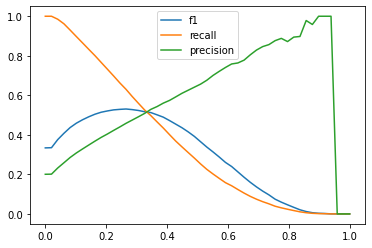

In [97]:
thresholds = np.linspace(0, 1)
f1_scores = []
recall_scores = []
precision_scores = []

for t in thresholds:
    y_pred_new = (y_pred_prob >= t).astype(int)
    f1_scores.append(f1_score(yval, y_pred_new, average="micro"))
    recall_scores.append(metrics.recall_score(yval, y_pred_new, average="micro"))
    precision_scores.append(metrics.precision_score(yval, y_pred_new, average="micro"))

plt.plot(thresholds, f1_scores, label='f1')
plt.plot(thresholds, recall_scores, label='recall')
plt.plot(thresholds, precision_scores, label='precision')
plt.legend()
plt.show()